### NeighborHood class is defined which extracts all data and plots maps

In [564]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import pandas as pd
import requests

class NeighborHood:
    CLIENT_ID = 'HLA3MIYDXWRD1MTILQ0M0J3XMH5TNFAOPTPBZRHMMU53YXL4' # your Foursquare ID
    CLIENT_SECRET = 'CILVKEPKXAUDTC3FEA0KU2F5VNZM33XASCFYI3JZQIAEYEJX' # your Foursquare Secret
    VERSION = '20180604'
    LIMIT = 100
    def __init__(self,place,search_query):
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(place)
        self.latitude = location.latitude
        self.longitude = location.longitude
        self.pull_foursquare_data(search_query)
        
    def pull_foursquare_data(self,search_query):
        #for search_query in ['Food','coffee','Nightlife','Shopping','Fun']:
        #search_query = 'Food'
        radius = 2000
        print(search_query + ' .... OK!')
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},\
            {}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
                                                        self.latitude, self.longitude, VERSION, 
                                                        search_query, radius, LIMIT)

        
        results = requests.get(url).json()

        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # tranform venues into a dataframe
        from pandas.io.json import json_normalize
        required_frame=json_normalize(venues)
        required_frame = required_frame.loc[:,['name','categories','location.lat','location.lng']]
        required_frame['categories'] = required_frame.apply(get_category_type,axis=1)
        self.dataframe = required_frame
    
    @staticmethod
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
        
    def plot_map(self):
        df=self.dataframe

        #print(df.head())
        self.venues_map=folium.Map([self.latitude, self.longitude], zoom_start=13)
        #print(type(venues_map))
        folium.CircleMarker(location=[self.latitude, self.longitude],radius=10,color='red',
                                 popup='Center Location',fill = True,fill_color = 'red',fill_opacity = 0.6
                                ).add_to(self.venues_map)
        for lat, lng, nm,ctg in zip(df['location.lat'], df['location.lng'], df['name'],df['categories']):
            #print(lat,lng,label)
            label = '{}, {}'.format(nm, ctg)
            folium.CircleMarker([lat, lng],radius=10,color='blue',fill = True,popup=folium.Popup(label,parse_html=True),
                                fill_color='blue',fill_opacity=0.6).add_to(self.venues_map)
            
        
    def cluster_data(self,num_clusters):
        X = self.dataframe.values[:,2:]
        X = pd.np.nan_to_num(X)
        
        from sklearn.preprocessing import StandardScaler
        cluster_dataset = StandardScaler().fit_transform(X)
        
        from sklearn.cluster import KMeans 
        from sklearn.datasets.samples_generator import make_blobs
        #num_clusters = 4

        k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
        k_means.fit(cluster_dataset)
        labels = k_means.labels_

        self.dataframe['labels'] = labels
        #print(labels)
        
    def plot_cluster(self):
        color_map = {0:'blue',1:'red',2:'green',3:'orange',4:'magenta',5:'cyan'}
        
        df=self.dataframe
        self.cluster_map=folium.Map([self.latitude, self.longitude], zoom_start=13)
        for lat, lng, nm,ctg,label_color in zip(df['location.lat'], df['location.lng'], df['name'],df['categories'],df['labels']):
            label = '{}, {}'.format(nm, ctg)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker([lat, lng],radius=5,popup=label,color=color_map[label_color],
                                fill=True,fill_color='white',
                                fill_opacity=0.7,parse_html=False).add_to(self.cluster_map)



Shopping .... OK!


In [614]:
data = pd.DataFrame(data=None,columns=['Food','coffee','shopping','fun','Nightlife'],index=['Toronto','New York'])

In [615]:
data

,Food,coffee,shopping,fun,Nightlife
Toronto,NaN,NaN,NaN,NaN,NaN
New York,NaN,NaN,NaN,NaN,NaN


In [616]:
for i in data.index:
    for j in data.columns:
        data.loc[i,j]=NeighborHood(i,j)

Food .... OK!
coffee .... OK!
shopping .... OK!
fun .... OK!
Nightlife .... OK!
Food .... OK!
coffee .... OK!
shopping .... OK!
fun .... OK!
Nightlife .... OK!


In [617]:
for i in data.index:
    for j in data.columns:
        count_data.loc[i,j]=data.loc[i,j].dataframe.shape[0]

In [618]:
count_data

,Food,coffee,shopping,fun,Nightlife
Toronto,50,50,6,49,1
New York,50,50,12,50,3


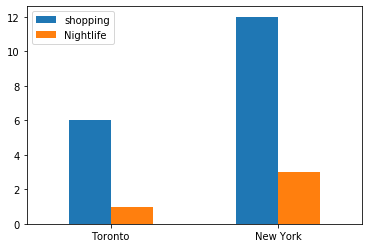

In [628]:
ax = count_data.plot.bar(y=['shopping','Nightlife'],rot=0)